# Power Analysis for Proportion Metric at Group Size of 500

*A brief exploration of how often one is able to identify significant differences for various effect sizes.  We'll base this around a hypothetical research design where we are looking at how using social media impacts communication with friends and family.*
<br><br>
**Manipulation:** Using Social Media or Not Using Social Media
<br>
**Measurement:** % Answering "Yes" to "Have you communicated with a friend or family member in the past 24 hours?"


First, we will define the functions to conduct a simulation and evaluate our ability to detect the correct effects.

In [1]:
# import necessary libraries
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import random
%matplotlib inline

# cleaning notebook
import warnings
warnings.filterwarnings("ignore")

In [2]:
# returns 1 if "Yes" and 0 if "No"
def simulate_response(likelihood_of_yes):
    
    random_number = random.random()
    
    if random_number < likelihood_of_yes:
        return 1
    else:
        return 0

# can simulate set of responses
def simulate_responses(
    initial_likelihood_of_yes,
    number_of_exposures=1,
    likelihood_of_repeat=0, # how likely is the R to repeat the last wave?
    likelihood_of_revert=0 # how likely is the R to repeat first survey?
):
    
    # initialize response list
    responses = []
    
    # simulate first response
    r = simulate_response(initial_likelihood_of_yes)
    responses.append(r)
    
    
    # simulate additional responses
    for additional_exposure in range(number_of_exposures-1):
        
        # roll for various events
        roll_for_events = random.random()
    
        # if the roll is within the repeat range, response is last item in list
        if roll_for_events <= likelihood_of_repeat:            
            r = responses[-1]

        # if the roll is within the revert range, response is first item in list
        elif roll_for_events <= likelihood_of_repeat + likelihood_of_revert:
            r = responses[0]

        # otherwise, generate a new response based on likelihood
        else:
            r = simulate_response(initial_likelihood_of_yes)
        
        # append the new response to the list of responses
        responses.append(r)
        
    return responses


# create a list of responses based on a given likelihood    
def sample_n_responses(
    sample_size,
    initial_likelihood_of_yes,
    number_of_exposures_per_respondent=1,
    likelihood_of_repeat=0,
    likelihood_of_revert=0
):
    
    #initialize responses
    responses = []
    
    #append response(s) for every respondent
    for respondent in range(sample_size):
        responses.extend(
            simulate_responses(
                initial_likelihood_of_yes,
                number_of_exposures=number_of_exposures_per_respondent,
                likelihood_of_repeat=likelihood_of_repeat,
                likelihood_of_revert=likelihood_of_revert
            )
        )
        
    return responses


# get p value comparing two groups with different true likelihoods
def simulate_two_group_test(
    group_size, 
    g1_likelihood, 
    g2_likelihood,
    number_of_exposures_per_respondent=1,
    likelihood_of_repeat=0,
    likelihood_of_revert=0
):
    
    group_1 = sample_n_responses(
        group_size, 
        g1_likelihood,
        number_of_exposures_per_respondent=number_of_exposures_per_respondent,
        likelihood_of_repeat=likelihood_of_repeat,
        likelihood_of_revert=likelihood_of_revert
    )
    
    group_2 = sample_n_responses(
        group_size, 
        g2_likelihood,
        number_of_exposures_per_respondent=number_of_exposures_per_respondent,
        likelihood_of_repeat=likelihood_of_repeat,
        likelihood_of_revert=likelihood_of_revert
    )
    
    stats = {
        'group_1_mean': np.mean(group_1),
        'group_2_mean': np.mean(group_2),
        'p_value': sp.stats.ttest_ind(group_1,group_2)[1]
    }
    return stats


# see how often a ttest identifies the correct effect
def estimate_statistical_power(
    g1_likelihood, g2_likelihood, group_size, 
    x_per_respondent=1,
    likelihood_of_repeat=0,
    likelihood_of_revert=0,
    simulations=10000, p=.05
):
    
    correct_effect_identified_tracker = []
    
    if g1_likelihood == g2_likelihood:
        return "error - input differing likelihoods"
    
    if g1_likelihood > g2_likelihood:
        gmean = 'group_1_mean'
        lmean = 'group_2_mean'
        
    if g2_likelihood > g1_likelihood:
        gmean = 'group_2_mean'
        lmean = 'group_1_mean'
        
    for i in range(simulations):
        
        stats = simulate_two_group_test(
            group_size, g1_likelihood, g2_likelihood,
            number_of_exposures_per_respondent=x_per_respondent,
            likelihood_of_repeat=likelihood_of_repeat,
            likelihood_of_revert=likelihood_of_revert
        )
        
        if (stats[gmean] > stats[lmean]) & (stats['p_value'] < p):
            correct_effect_identified_tracker.append([1])
            
        else:
            correct_effect_identified_tracker.append([0])
            
    return np.mean(correct_effect_identified_tracker)

    
# run simulations for combinations of specified ranges, return to dataframe
def get_powers_for_ranges(
    initial_likelihood_range,
    percentage_point_difference_range,
    n_per_group,
    x_per_respondent=1,
    likelihood_of_repeat=0,
    likelihood_of_revert=0,
    simulations=10000, p=.05
):
    
    results = pd.DataFrame()
    for likelihood in initial_likelihood_range:
        for ppdiff in percent_point_difference_range:
            n = n_per_group
            l1 = likelihood
            l2 = likelihood + ppdiff
            
            power = estimate_statistical_power(
                l1, l2,
                n_per_group,
                x_per_respondent=x_per_respondent,
                likelihood_of_repeat=likelihood_of_repeat,
                likelihood_of_revert=likelihood_of_revert,
                simulations=simulations, p=p
            )
            
            row = {
                'starting_likelihood':l1, 
                'percentage_point_difference': ppdiff, 
                'power': power
            }
            
            results = results.append(row, ignore_index= True)
    return results

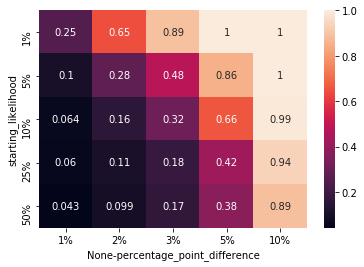

In [3]:

# let's look at a range of initial likelihoods from 1% to 50%
initial_likelihood_range = [.01,.05,.1,.25,.5]

# let's look at percentage point differences from 1% to 10%
percent_point_difference_range = [.01, .02, .03, .05, .10]


# we can keep sample size constant at 500
sample_size = 500

results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                simulations=2000, p=.05)


# look at color-coded grid of results
reformatted = results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

Capturing only a single exposure, we reliably have a 90%+ chance of detecting effect sizes of 10 percentage points, with our power to detect effect sizes of 5 percentage points ranging from ~36% to 100% depending on the starting likelihood.

Let's run that again except look at how likely we are to hit a p-value of 10%.

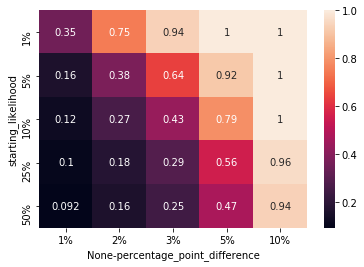

In [4]:
# look at color-coded grid of results
p10_results = get_powers_for_ranges(initial_likelihood_range,
                                    percent_point_difference_range,
                                    sample_size,
                                    simulations=2000, p=.1)

p10_reformatted = p10_results.pivot(index='starting_likelihood', 
                                    columns='percentage_point_difference')

ax = sns.heatmap(p10_reformatted, annot=True, 
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

By adjusting to a p=10% standard, we get some help with 5 percentage point effect sizes, giving us -- at worst -- ~50/50 odds.
<br>
Similarly, power is boosted for 10 percentage point effects so we capture them nearly 95% of the time.
<br><br>
Since these numbers are lower than ideal, let's plan on pulling six distinct measures from each respondent.  How does this change our analysis?

Text(0.5,1,'0% Chance of Longitudinal Repetition/Reversion')

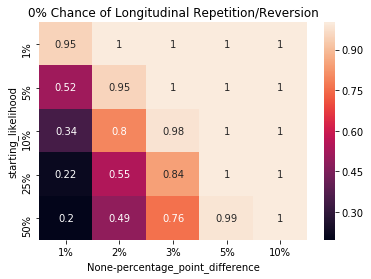

In [5]:
# first let's try this assuming that each longitudinal measure has no bearing on the others -- an unlikely but ideal scenario
cluster_results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=6,
                                likelihood_of_repeat=0,
                                likelihood_of_revert=0,
                                simulations=2000, p=.1)


# look at color-coded grid of results
cluster_reformatted = cluster_results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(cluster_reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('0% Chance of Longitudinal Repetition/Reversion')

If there's no interaction between each survey, we nearly guarantee our ability to detect differences with an effect size of 5% of more;  however this scenario is unlikely, so we should look at a variety of different interaction options.
<br><br>
*We look at two types of interaction within a respondents wave-to-wave responses:*
<br>
**Repetition:** How likely is the respondent to echo the response provided last wave?
<br>
**Reversion:** How likely is the respondent to revert to their very first response?
<br>

Text(0.5,1,'50% Chance of Longitudinal Repetition')

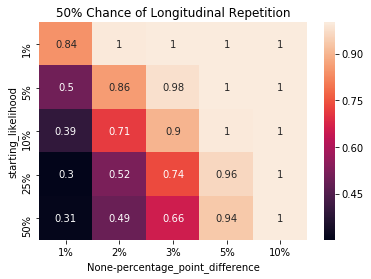

In [6]:
# now let's see what happens if the odds of a repeat are 50%
cluster_results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=6,
                                likelihood_of_repeat=0.5,
                                simulations=2000, p=.1)


# look at color-coded grid of results
cluster_reformatted = cluster_results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(cluster_reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('50% Chance of Longitudinal Repetition')

Text(0.5,1,'50% Chance of Longitudinal Reversion')

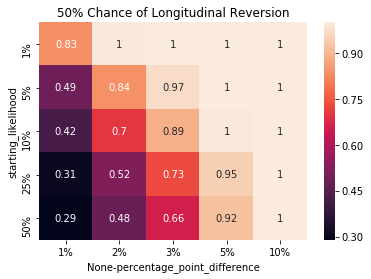

In [7]:
# now let's see what happens if the odds of reversion are 50%
cluster_results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=6,
                                likelihood_of_revert=0.5,
                                simulations=2000, p=.1)


# look at color-coded grid of results
cluster_reformatted = cluster_results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(cluster_reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('50% Chance of Longitudinal Reversion')

Even with moderate degrees of repetition or reversion, we should be able to detect over 9 in 10 effects of 5 percentage points or more.
<br><br>
Let's turn up the interaction and see how that impacts our statistical power.

Text(0.5,1,'99% Chance of Longitudinal Repeats')

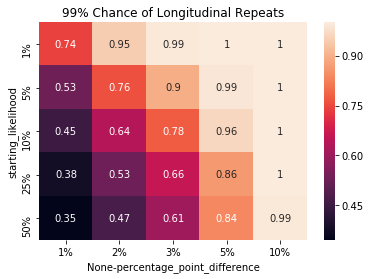

In [8]:
# now let's see what happens if the odds of a repeat are 99%
cluster_results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=6,
                                likelihood_of_repeat=0.99,
                                simulations=2000, p=.1)


# look at color-coded grid of results
cluster_reformatted = cluster_results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(cluster_reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('99% Chance of Longitudinal Repeats')

Text(0.5,1,'99% Chance of Longitudinal Reversion')

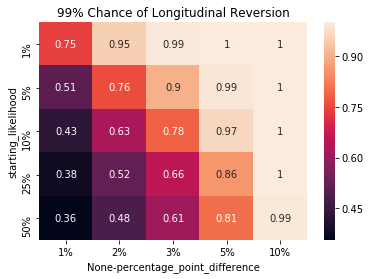

In [9]:
# lastly, let's see what happens if the odds of reversion are 99%
cluster_results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=6,
                                likelihood_of_revert=0.99,
                                simulations=2000, p=.1)


# look at color-coded grid of results
cluster_reformatted = cluster_results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(cluster_reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('99% Chance of Longitudinal Reversion')

More interaction certainly makes effect sizes harder to detect, but we're still capturing 80%+ of effects 5%+.
<br><br>
These all focus on broader group-to-group comparisons, though, and we also want to look at subgroups within each group.  Let's investigate some scenarios for subsets of 100 respondents to assess our power in those scenarios.

Text(0.5,1,'n=100 Comparisons, Single Metric')

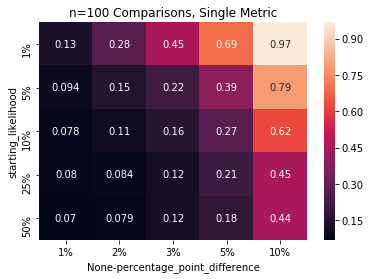

In [10]:
# let's get a baseline by looking at statistical power for a single wave only

sample_size = 100

results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                simulations=2000, p=.1)


# look at color-coded grid of results
reformatted = results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('n=100 Comparisons, Single Metric')

We're underpowered to evaluate single-wave comparisons between groups for most effect sizes.  Fortunately, we will be asking the same metrics to respondents over the course of the study we can explore that helps give us the power we need.

Text(0.5,1,'n=100 Comparisons, Sequence of Six Metrics')

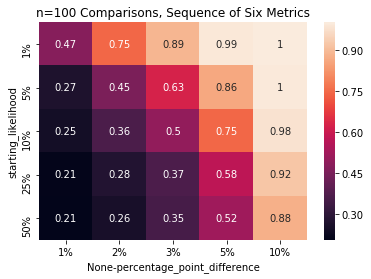

In [11]:
sample_size = 100

results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=6,
                                likelihood_of_repeat=0.5,
                                simulations=2000, p=.1)


# look at color-coded grid of results
reformatted = results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('n=100 Comparisons, Sequence of Six Metrics')

While the power is low for the n=100 comparisons, using a sequence of metrics lets us capture over 85% of effects that are 10 percentage points or more.  Lets see how getting twice as many metrics impacts -- or two measurements per week -- impacts this.

Text(0.5,1,'n=100 Comparisons, Sequence of Twelve Metrics')

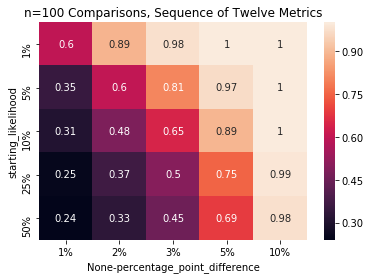

In [12]:
sample_size = 100

results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=12,
                                likelihood_of_repeat=0.5,
                                simulations=2000, p=.1)


# look at color-coded grid of results
reformatted = results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('n=100 Comparisons, Sequence of Twelve Metrics')

Doubling the frequency of metric collection substantially improves our statistical power so we can nearly guarantee that effects of 10%+ will be captured within our design, even assuming that respondent responses are impacted by the prior wave.  Let's just do one more check to see what the impact of reversion could be.

Text(0.5,1,'n=100 Comparisons, Sequence of Twelve Metrics')

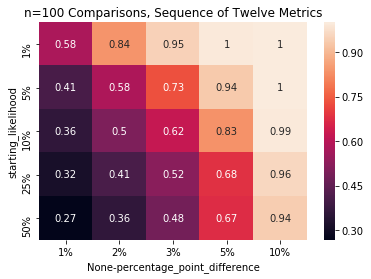

In [13]:
sample_size = 100

results = get_powers_for_ranges(initial_likelihood_range,
                                percent_point_difference_range,
                                sample_size,
                                x_per_respondent=12,
                                likelihood_of_revert=0.50,
                                simulations=2000, p=.1)


# look at color-coded grid of results
reformatted = results.pivot(index='starting_likelihood', 
                            columns='percentage_point_difference')

ax = sns.heatmap(reformatted, annot=True,
                  xticklabels=['1%','2%','3%','5%','10%'],
                  yticklabels=['1%','5%','10%','25%','50%'])

ax.set_title('n=100 Comparisons, Sequence of Twelve Metrics')

While reversion reduces our power more than repetition does, we still are able to detect 10%+ effects ~19 in 20 times.